# A first look into Target Volatiliy Strategy using Python 

### this work is done only for education purpose and it represente my first effective financial project using Python. 

## 1- Strategy description 

The constituents of the Index are (a) the Underlying Index, (b) a hypothetical deposit based on the LIBOR Rate and (c) a hypothetical borrowing based on the LIBOR Rate, with a deemed allocation to each depending on the volatility of the Underlying Index relative to the target volatility . 
exposure of the level of the Index to the Underlying Index is computed on each calculation date of the Index and is equal to the ratio of the Target Volatility to the 1-month historical volatility of the Underlying Index (the “Historical Volatility”), expressed as a percentage, with the maximum deemed exposure of the Index to the Underlying Index being capped at 200% of the Index level (the “Exposure”). 
* If the Historical Volatility is greater than the Target Volatility, then the Exposure of the Index to the Underlying Index will be less than 100%. In such case, a percentage of the Index’s level is deemed invested in the Underlying Index in an amount equal to the Exposure and the remaining percentage of the Index’s level is deemed invested in the hypothetical deposit based on the LIBOR Rate.
* If the Historical Volatility is equal to the Target Volatility, then the Exposure of the Index to the Underlying Index will be 100%. In such case, 100% of the Index’s level is deemed invested in the Underlying Index and no portion of the Index’s level is deemed invested in the hypothetical deposit based on the LIBOR Rate.
* If the Historical Volatility is less than the Target Volatility, then the Exposure of the Index to the Underlying Index will be greater than 100% (subject to a maximum Exposure of 200%). In such case, 100% of the Index’s level is deemed invested in the Underlying Index and no portion of the Index’s level is deemed invested in the hypothetical deposit based on the LIBOR Rate. Furthermore, (a) the Index is deemed to have invested an additional amount into the Underlying Index equal to the product of (i) the Index Level and (ii) the difference of the Exposure and 100% (the “Additional Exposure”) and (b) the Index is deemed to have borrowed funds equal to the product of (i) the Index Level and (ii) the Additional Exposure at a rate based on the LIBOR Rate. The deemed additional investment in the Underlying Index will increase the Index’s exposure to the Underlying Index, while the deemed borrowing will reduce the level of the Index.


## 2- Variables description : 

- ACT(t-1,t) : means the number of calendar days between the Calculation Date (t-1) (included) and the Calculation Date (t) (excluded).
- Exposure “E(t)” : means in respect of any Calculation Date (t), the target exposure to the Underlying Index expressed as a percentage of the Index Level, with a minimum of 0% and maximum of 200% (see formulas)
- Historical Volatility “HV(t)”: means in respect of any Calculation Date (t), the annualized historical volatility of the Underlying Index determined over the past 20 Calculation Dates (see formulas).
- Index Launch Date “t0”. 
- Index Level “IL(t)” : means in respect of any Calculation Date (t), the level of the Index calculated at the Valuation Time, pursuant to the Index formulas.
- Replication Fee  “Fee”: means 1.75% per annum.
- Transaction Cost “C(t)” : means in respect of any Calculation Date (t), the transaction cost related to the Underlying Index.
- Target Volatility, “TV”
- Underlying Index Level "UIL(t)" : means in respect of any Calculation Date (t), the official closing price of the Underlying Index.
- LIBOR Rate "LR(t)" :means in respect of any Calculation Date (t), the percentage rate of the 1-month London interbank offered rate for deposits in US dollars. 














## 3- Formulas

#####  - The Index Level : 

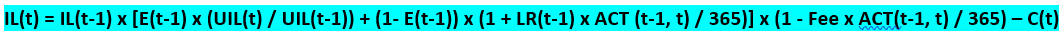

#####  - The Exposure to the Underlying Index

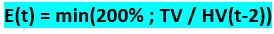

##### - The Historical Volatility 

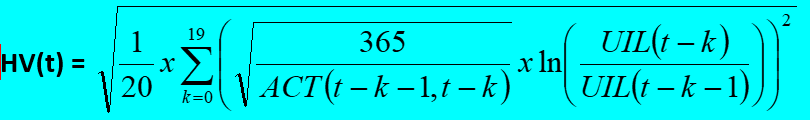

##### -The transaction cost 

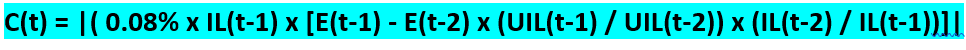

## Creating a class named Voltarget :  

our class named Volarget takes two DataFrames for LR and UIL that are having one columns (values) and are indexed by date.
Also this data must be cleaned before using it in Voltarget

In [228]:
# importing modules we need
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import matplotlib as mpl

In [240]:
class Voltarget:
    """Class attributes :
    - Calandar 
    - t0 : Index Launch Date 
    - ix0 : the index of ix0 in dataFrame
    - amount : IL(t0)
    - Fee : Replication 1.75% per annum
    - TV : Target volatility choosen by user
    - data : a dataFrame that countains (Date = calandar, UI,LR,ACT, log_return_UIL, HV, Exposition,Transaction_Cost,IL)
    """
    calandar = 0
    t0 = 0 
    ix0 = 0 
    TV = 0.00010
    amount = 0 
    Fee = 0.0175
    data = pd.DataFrame()
    
    def __init__(self, LR, UI,TV, t0) :
        self.LR = LR
        self.UI = UI
        self.t0 = t0
        self.TV = TV
        
    def set_calandar(self):
        self.calandar =  self.LR.index.intersection(self.UI.index)
        self.data['Date'] = self.calandar 
        self.data['UI'] = self.UI.reset_index().iloc[:,1]
        self.data['LR'] = self.LR.reset_index().iloc[:,1]
        self.ix0 = self.data[self.data.Date == self.t0].index.values[0]
    def _ACT(self) : 
        self.data['ACT'] = (self.data.Date.diff(1)/np.timedelta64(1,'D'))
        
    def _HV(self) : 
        self.data['log_return_UIL'] =  np.log(self.UI/self.UI.shift(1)).reset_index().iloc[:,1]
        self.data['HV'] = np.power(np.sqrt(365/self.data.ACT)*self.data.log_return_UIL,2).rolling(20).std()
        
    def set_exposure(self):
         self.data['Exposition'] =  np.where(self.data.HV.shift(2).isna() ,None ,np.minimum(2,self.TV/self.data.HV.shift(2)))
            
    def index_level(self,IL0) : 
        self.amount = IL0
        LR = self.data.LR
        UIL =self.data.UI
        ACT =self.data.ACT
        E = self.data.Exposition
        C = [0]*len(LR)
        IL = [0]*len(LR)
        
        IL[self.ix0] = self.amount
        for i in range(self.ix0 +1,len(LR) ) : 
    
            if (i > (self.ix0+1))  : 
                 C[i] = np.abs(0.0008 *IL[i-1]*(E[i-1]-(E[i-2]*UIL[i-1]*IL[i-2])/(UIL[i-2]*IL[i-1])))
                 IL[i] = IL[i-1]*(E[i-1]*(UIL[i]/UIL[i-1]) + (1-E[i-1])*(1+LR[i-1]*(ACT[i]/365.0)))*(1-self.Fee*(ACT[i]/365.0)) - C[i]
            if (i == (self.ix0+1)) : 
                 IL[i] = IL[i-1]*(E[i-1]*(UIL[i]/UIL[i-1]) + (1-E[i-1])*(1+LR[i-1]*(ACT[i]/365.0)))*(1-self.Fee*(ACT[i]/365.0)) - C[i]
        
        self.data['Transaction_Cost'] = C
        self.data['IL'] = IL
    def get_allresults(self, amount) : 
        self.set_calandar()
        self._ACT()
        self._HV()
        self.set_exposure()
        self.index_level(amount)
        self.data['Log_return_IL'] = (self.data.IL/self.data.IL.shift(1)).reset_index().iloc[:,1]
        self.data = self.data[self.data['Date'] >= self.t0] 
        self.data.set_index('Date', inplace = True)
        
        return self.data

## 4- Backtesting  

In our backtesting we will take data of LR and ADJ close of SPTRBRIC ranged between 2007 and 2017. 
then we will check the performance of our strategy for two different launch dates : ( 2007-04-17 , 2013-01-29) 

## Loading data of LR & UIL  from Excel files

In [241]:
LR = pd.read_excel(r'LIBOR.xlsx', index_col=0)
UIL = pd.read_excel(r'UIIL.xlsx', index_col=0)
LR = LR[LR.index == LR.index.intersection(UIL.index)]/100


### Ploting LR & UI :  

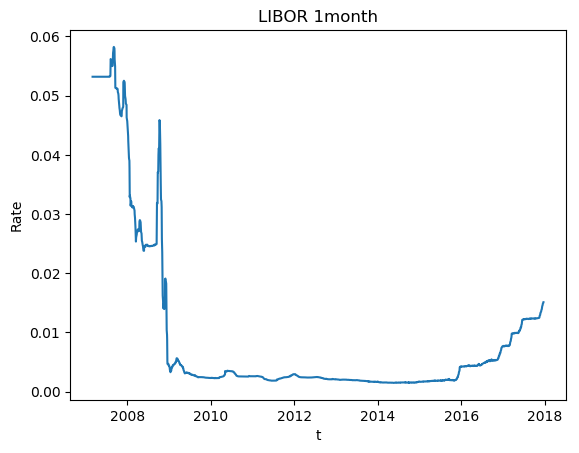

In [243]:
# LR ploting :
plt.plot(LR.index, LR)
plt.title('LIBOR 1month')
plt.ylabel('Rate')
plt.xlabel('t')
plt.show()

we see here that our backtesting is done from 2007-2008 financial crisis where Libor rate had been 
spiked to sky-high levels in 2008 and 2009 during the financial crisis, as the banks appeared to be on the edge of collapse. and after 2009 the libor rate decreases to maintain a stable level till 2016 and then it goeas up.

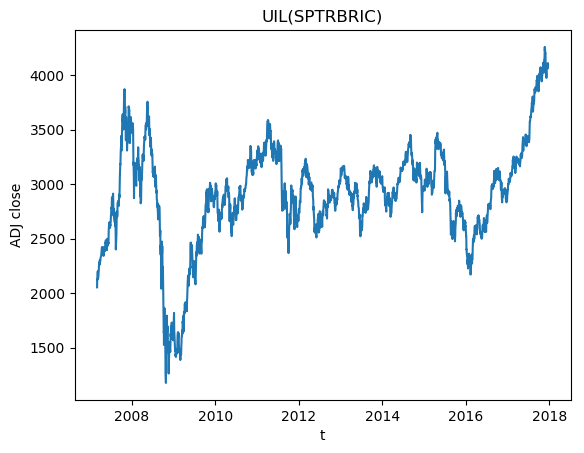

In [244]:
plt.plot(UIL.index, UIL)

plt.title('UIL(SPTRBRIC)')
plt.ylabel('ADJ close')
plt.xlabel('t')
plt.show()

We marely observe that the ADJ close tendance is likely the same as of Libor rate

### Backtesting for launch date = 2007-04-18

In [264]:
A = Voltarget(LR,UIL,0.18,'2007-04-18')
df = A.get_allresults(2300)
df.describe()
x = df[df.index > A.t0]
x.log_return_UIL.std() , x.Log_return_IL.std()


(0.017114325858831485, 0.02128695927445767)

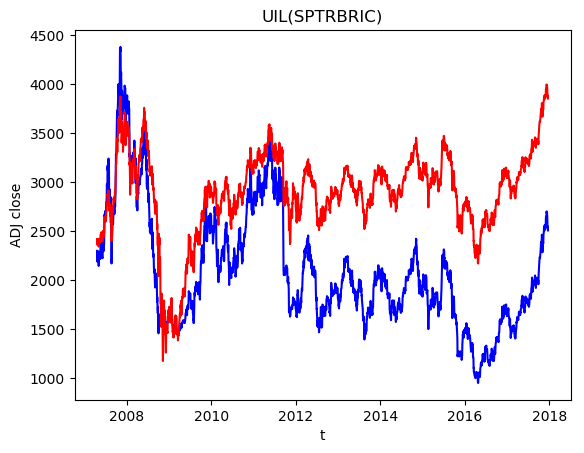

In [265]:
plt.plot(df.index, df.IL, color = 'b')
plt.plot(df.index, df.UI, color = 'r')
plt.title('UIL(SPTRBRIC)')
plt.ylabel('ADJ close')
plt.xlabel('t')
plt.show()


### Backtesting while launch date is 2013-01-29

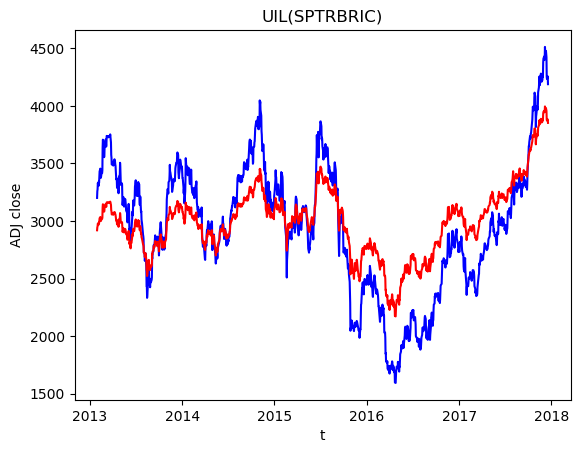

In [254]:
A2 = Voltarget(LR,UIL,0.18,'2013-01-29')
df2 = A2.get_allresults(3200)
plt.plot(df2.index, df2.IL, color = 'b')
plt.plot(df2.index, df2.UI, color = 'r')
plt.title('UIL(SPTRBRIC)')
plt.ylabel('ADJ close')
plt.xlabel('t')
plt.show()

we observe that when the UIL is volatil the IL mimics the movements of UIL. Hence when UIL is less volatil in a 
short periode and after increases in volatility we observe that the ampletude of IL movements are much important that those of UIL, this stay valid in both increase or decrease of UIL.


## Conclusion : 

#### In term of this work I was able to implemente the Volatiliy target Strategy using Python. 
#### This project was a good first step for me to learn new methods of pandas Library that i found very powerful and I'm very glad for that.

#### For my next work i will study more the Volatility Target Strategy in order to delevope more this actual work.